In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy import optimize
#from noisyopt import minimizeCompass
from scipy.optimize import curve_fit 
from mpl_toolkits import mplot3d

In [35]:
class simple_qubit:
    # pauli matrices
    sx = np.matrix([[0,1],[1,0]])
    sy = np.matrix([[0,-1j],[1j,0]])
    sz = np.matrix([[1,0],[0,-1]])
    
    # constants: capitalize, call via self.sx
    
    #@staticmethod
    def get_pauli(xx, yy, zz):
        return xx*self.sx+yy*self.sy+zz*self.sz
    
    @staticmethod
    def fidelity_bound(fidelity):
        return np.max([np.min([np.abs(fidelity), 1]), 0])
    @staticmethod
    def sampling_bound(number_of_tries):
        return np.max([1, np.round(number_of_tries)])
    
    def get_correct_measurement_fidelity(self, fidelity):
        if fidelity == 'default': 
            res = self.measurement_fidelity
        else:
            res = self.fidelity_bound(fidelity) 
        return res
        
    def get_correct_initialization_fidelity(self, fidelity):
        if fidelity == 'default': 
            res = self.initialization_fidelity
        else:
            res = self.fidelity_bound(fidelity) 
        return res
    
    def get_correct_number_of_measurements(self, number_of_tries):
        if number_of_tries == 'default': 
            res = self.number_of_measurements
        else:
            res = self.sampling_bound(number_of_tries)  
        return res
    
    def __init__(self, frequency, g_factor):
        self.frequency = frequency
        self.g_factor = g_factor
        self.state = np.matrix([[1,0],[0,1]])/2
        # self.gamma = 1e-1 # for later
        
        self.measurement_fidelity = 1
        self.initialization_fidelity = 1
        self.number_of_measurements = 100
        # self.n_inits = 0 # for later
        self.n_meas = 0
        
    def normalize(self):
        self.state = self.state/np.trace(self.state)
        
    def initialize(self, fidelity = 'default'):       
        fidelity = self.get_correct_initialization_fidelity(fidelity)
        self.state = np.matrix([[fidelity,0],[0,1-fidelity]])
        self.normalize()
        
    def apply_simple_pulse(self, frequency, amplitude, time):
        detuning = 2*np.pi*(frequency - self.frequency)
        rabi_frequency = np.pi*amplitude*self.g_factor
        
        # apply pulse
        pulse_hamiltonian = rabi_frequency*np.matrix([[0,1],[1,0]])+detuning/2*np.matrix([[1,0],[0,-1]])
        evolution = la.expm(1j*pulse_hamiltonian*time)
        
        self.state = evolution*self.state*evolution.conj().T
        self.normalize()
    
    def measure(self, number_of_tries = 'default', fidelity = 'default'):
        fidelity = self.get_correct_measurement_fidelity(fidelity)
        number_of_tries = self.get_correct_number_of_measurements(number_of_tries)
        
        measurement_operator = (2*fidelity-1)*self.sz # = F*sz + (1-F) sz^(-1), use linearity of matrix and trace
        
        probability_1 = np.abs(np.trace(measurement_operator*self.state)+1)/2
        number_of_tries = np.round(number_of_tries)
        avg_result = np.random.binomial(number_of_tries,probability_1)/number_of_tries
        self.initialize(fidelity = fidelity)
        self.n_meas += number_of_tries
        return avg_result
    
    def get_state(self):
        return self.state
    
    def set_control_parameters(self, initialization_fidelity = 'skip', measurement_fidelity = 'skip', number_of_measurements = 'skip'):
        if measurement_fidelity!='skip':
            self.measurement_fidelity = self.fidelity_bound(measurement_fidelity)
        if initialization_fidelity!='skip':
            self.initialization_fidelity = self.fidelity_bound(initialization_fidelity)
        if number_of_measurements!='skip':
            self.number_of_measurements = self.sampling_bound(number_of_measurements)
    
    def run_pulse_experiment(self, frequency, amplitude, time):
        #one of them can be an array. check which one
        n_scan = 0
        n_res = 1
        if np.size(frequency) > 1:
            scan = 'freq'
            n_res = np.size(frequency)
            n_scan += 1
        if np.size(amplitude) > 1:
            scan = 'amp'
            n_res = np.size(amplitude)
            n_scan += 1
        if np.size(time) > 1:
            scan = 'time'
            n_res = np.size(time)
            n_scan += 1
        
        if n_scan == 0:
            self.initialize()
            self.apply_simple_pulse(frequency, amplitude, time)
            result = self.measure()
        elif n_scan == 1:        
            if scan is 'freq':
                result = np.empty(n_res)
                for kk in np.arange(n_res):
                    self.initialize()
                    self.apply_simple_pulse(frequency[kk], amplitude, time)
                    result[kk] = self.measure()
            elif scan is 'amp':
                result = np.empty(n_res)
                for kk in np.arange(n_res):
                    self.initialize()
                    self.apply_simple_pulse(frequency, amplitude[kk], time)
                    result[kk] = self.measure()
            elif scan is 'time':
                result = np.empty(n_res)
                for kk in np.arange(n_res):
                    self.initialize()
                    self.apply_simple_pulse(frequency, amplitude, time[kk])
                    result[kk] = self.measure()
        elif n_scan == 2:
            #need to do it iteratively. one of them should be frequency for now, because I'm rushing thru this instead of coding properly.    
            
            if np.size(frequency) > 1:
                n_total = np.size(frequency)
                res_size = np.shape(frequency)
                result = np.empty(n_total)
                ff = frequency.flatten()
                if scan is 'amp':
                    aa = amplitude.flatten()
                    for ind_k, f_element in enumerate(ff):
                        self.initialize()
                        self.apply_simple_pulse(f_element, aa[ind_k], time)
                        result[ind_k] = self.measure()
                elif scan is 'time':
                    tt = time.flatten()
                    for ind_k, f_element in enumerate(ff):
                        self.initialize()
                        self.apply_simple_pulse(f_element, amplitude, tt[ind_k])
                        result[ind_k] = self.measure()
            else: 
                n_total = np.size(amplitude)
                res_size = np.shape(amplitude)
                result = np.empty(n_total)
                tt = time.flatten()
                aa = amplitude.flatten()
                for ind_k, t_element in enumerate(tt):
                    self.initialize()
                    self.apply_simple_pulse(frequency, aa(ind_k), t_element)
                    result[ind_k] = self.measure()
            result = np.reshape(result, res_size)

            
        return result 
    def get_n_measurements(self):
        return self.n_meas

basic functionality:
1. create qubit object.
2. initialize it
3. apply pulse
4. measure the resulting statistics

In [253]:
qu = simple_qubit(5,1) # create it with give frequency and susceptibility to pulses
qu.initialize()
qu.apply_simple_pulse(4.99, 0.2, 0.25)
qu.measure(number_of_tries = 200)

0.99

a bit more advanced (useful for the optimizations):
you can set the initialization and measurement parameters, such that you can call the `measure` routine without parameters, or use the `run_pulse_experiment` routine. 
in `run_pulse_experiment`, it automatically initializes, applies a pulse, and measures. you can scan one of the pulse parameters in this routine.

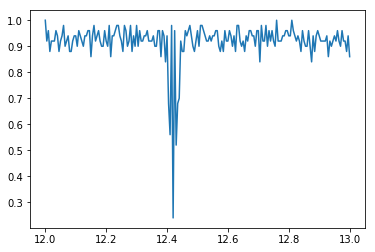

In [39]:
# here are some typical parameters
qu = simple_qubit(12.5+np.random.normal(0,0.1),np.abs(1+np.random.normal(0,0.2)))
qu.set_control_parameters(initialization_fidelity = 0.95, measurement_fidelity = 0.98, number_of_measurements = 50)
ff = np.linspace(12, 13, 201)
am = 0.01
tt = 200
res = qu.run_pulse_experiment(ff, am, tt)
plt.plot(ff, res)
# what you can see here is that the measurement is noisy and we underestimated how strongly the qubit can be driven. 
# Over-driving it results in multiple peaks
f_res_rough = ff[np.argmin(res)]

Tanh function coefficients:
[ 1.25849048 12.59999987  0.03736084]
Covariance of coefficients:
[[ 4.93145144e-04 -3.02130612e-08  3.41193291e-04]
 [-3.02130612e-08  2.76797466e-12 -2.77128390e-08]
 [ 3.41193291e-04 -2.77128390e-08  3.06179239e-04]]


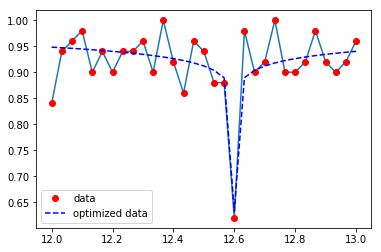

12.6
Frequency is 12.599999869413557. Correct f is 12.59070343164405
Error in initial frequency guess is 0.07383676699575725%
Error in fitted frequency is 0.07383572983017155%


0.0014815951154248136

In [265]:
qu.set_control_parameters(initialization_fidelity = 0.95, measurement_fidelity = 0.98, number_of_measurements = 50)

am = 0.01
tt = 30
x1 = np.linspace(12, 13, 31)

def opt_fct(x):
    return qu.run_pulse_experiment(x, am, tt)
y1=opt_fct(x1)
plt.plot(x1, y1)



# Test function with coefficients as parameters 
def test(x, a, b, c): 
    return a * np.tanh((np.abs(x-b))**c)

seed_freq = x1[np.argmin(y1)]

param, param_cov = curve_fit(test, x1, y1, p0=[1,seed_freq,.25])

param[2]=np.abs(param[2])

print("Tanh function coefficients:") 
print(param)
print("Covariance of coefficients:") 
print(param_cov)
  
# ans stores the fitted res data according to  
# the coefficients given by curve-fit() function 

ans = test(x1, param[0], param[1], param[2])
  
plt.plot(x1, y1, 'o', color ='red', label ="data") 
plt.plot(x1, ans, '--', color ='blue', label ="optimized data") 
plt.legend() 
plt.show() 

print(seed_freq)
print(f'Frequency is {param[1]}. Correct f is {qu.frequency}')
print(f'Error in initial frequency guess is {(np.abs(qu.frequency-seed_freq)/qu.frequency)*100}%')
print(f'Error in fitted frequency is {(np.abs(qu.frequency-param[1])/qu.frequency)*100}%')
np.sum(param_cov)

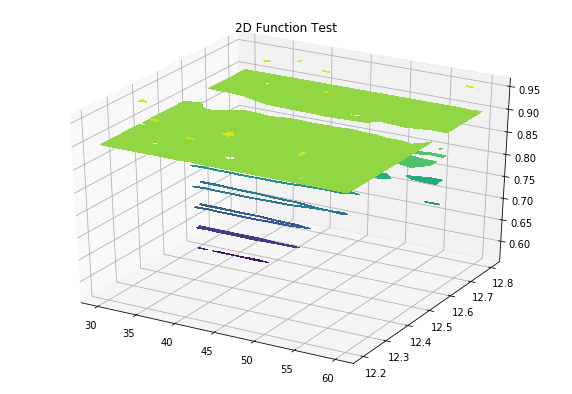

(20, 20)

In [278]:
qu.set_control_parameters(initialization_fidelity = 0.95, measurement_fidelity = 0.98, number_of_measurements = 500)

am = 0.01
f1 = np.linspace(12.2, 12.8, 20)
t1 = np.linspace(30, 60, 20)

def opt_fct(f,t):
    return qu.run_pulse_experiment(f, am, t)

fct_value = np.empty([np.size(f1), np.size(t1)])
for ind_f, freq in enumerate(np.size(f1)):
        fct_value[ind_f] = opt_fct(freq, t1)

# Creating figure 
fig = plt.figure(figsize = (10, 7)) 
ax = plt.axes(projection ="3d") 
  
# Creating plot 
#ax.scatter3D(f1, t1, fct_value, color = "blue"); 
ax.contourf(t1, f1, fct_value, color = "blue"); 
plt.title("2D Function Test") 
plt.show()
np.shape(fct_value)

## here's an example for plotting.
note that at this resolution it takes some time to run the code, at least on my laptop...

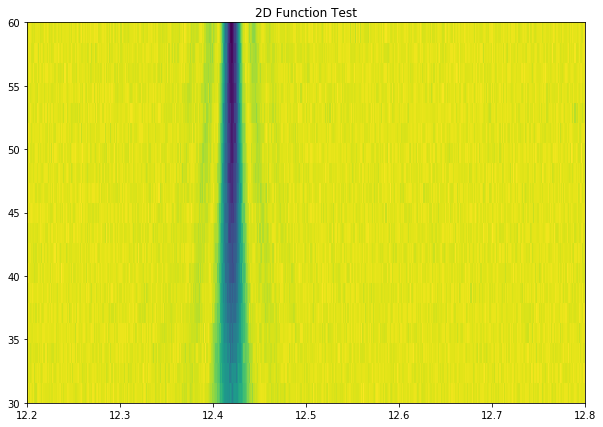

In [42]:
qu.set_control_parameters(initialization_fidelity = 0.95, measurement_fidelity = 0.98, number_of_measurements = 500)

am = 0.01
f1 = np.linspace(12.2, 12.8, 500)
t1 = np.linspace(30, 60, 20)

def opt_fct(f,t):
    return qu.run_pulse_experiment(f, am, t)

FF, TT = np.meshgrid(f1, t1)

# Creating figure 
fig = plt.figure(figsize = (10, 7)) 

RES = opt_fct(FF,TT)
plt.pcolor(FF,TT,RES)
plt.title("2D Function Test") 
plt.show()

In [257]:
# # Test function with coefficients as parameters 
# def test(x, a, b, c, d): 
#     return a * (np.abs(x - b))**c + d

# seed_freq = 12.5


# param, param_cov = curve_fit(test, x1, y1, p0=[-1,seed_freq,-4,1])

# print("Function coefficients:") 
# print(param)
# print("Covariance of coefficients:") 
# print(param_cov)
  
# # ans stores the fitted res data according to  
# # the coefficients given by curve-fit() function 

# ans = test(x1, param[0], param[1], param[2], param[3])
  
# plt.plot(x1, y1, 'o', color ='red', label ="data") 
# plt.plot(x1, ans, '--', color ='blue', label ="optimized data") 
# plt.legend() 
# plt.show() 

# print(seed_freq)
# print(f'Frequency is {param[1]}. Correct f is {qu.frequency}')
# print(f'Error in initial frequency guess is {(np.abs(qu.frequency-seed_freq)/qu.frequency)*100}%')
# print(f'Error in fitted frequency is {(np.abs(qu.frequency-param[1])/qu.frequency)*100}%')

After finding the rough resonance, we typically do a fine sweep to find the exact resonance

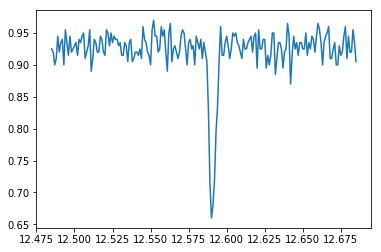

In [258]:
qu.set_control_parameters(number_of_measurements = 200)
ff = np.linspace(f_res_rough-.1, f_res_rough+.1, 201)
am = 0.001
tt = 200
res = qu.run_pulse_experiment(ff, am, tt)
plt.plot(ff, res)   
# we're now under-driving it, which is good to find the resonance. 
f_res = ff[np.argmin(res)]

0.06
(array([14], dtype=int64),)
[50.1980198]
50.198019801980195
0.031291997831614314


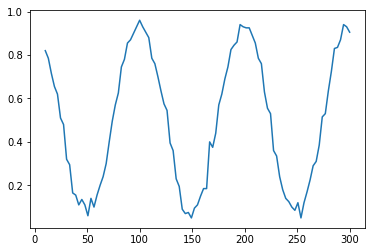

In [259]:
#next we set a reasonable (i.e. relatively high) value for the drive power and scan the time
tt_scan = np.linspace(10,300, 101)
am = 0.01
res = qu.run_pulse_experiment(f_res, am, tt_scan)
plt.plot(tt_scan, res)


#Find the first real minimum. 5 value trailing average can be adjusted based on linspace.
res_copy = res.copy()

res_copy[-1]=500
res_copy[-2]=500
res_copy[-3]=500
res_copy[-4]=500
res_copy[-5]=500
min1=500

for x in range(0,res.size-1):
    if res_copy[x] < min1:
        min1 = res_copy[x]
        x += 1
    elif res_copy[x] < .2*((res_copy[x-1])+(res_copy[x-2])+(res_copy[x-3])+(res_copy[x-4])+(res_copy[x-5])):
        x += 1
    else:
        print(min1)
        print(np.where(res == min1))
        mins = np.where(res == min1)[0]*(290/101)+10
        print(mins)
        half_cycle = mins[0]
        print(half_cycle)
        print(np.pi/(2*half_cycle))
        break
        

Cos function coefficients:
[0.43164771 0.06296395 0.         0.50543521]
Covariance of coefficients:
[[ 1.58576404e-05 -3.38950104e-08  4.56691539e-06  5.47887617e-07]
 [-3.38950104e-08  1.20496730e-08 -1.80629644e-06 -7.86320904e-08]
 [ 4.56691539e-06 -1.80629644e-06  3.52568273e-04  1.15089746e-05]
 [ 5.47887617e-07 -7.86320904e-08  1.15089746e-05  8.26391375e-06]]


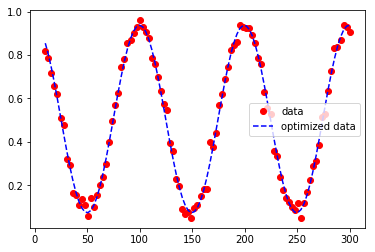

Calculated Pi-pulse time is: 49.89510234866713 sec


In [260]:
# Test function with coefficients as parameters 
def test(x, a, b, c, d): 
    return a * np.cos(b * x + c) + d

# we then fit a cosine to it and take the first minimum as time for our pi-pulse. 
  
# curve_fit() function takes the test-function 
# tt_scan and res as argument and returns  
# the coefficients a and b in param and 
# the estimated covariance of param in param_cov 
param, param_cov  = curve_fit(test, tt_scan, res, p0=[0.5,np.pi/(half_cycle),0,0.5])

# set phase shift to 0
param[2]=0

print("Cos function coefficients:") 
print(param)
print("Covariance of coefficients:") 
print(param_cov)
  
# ans stores the fitted res data according to  
# the coefficients given by curve-fit() function 

ans = test(tt_scan, param[0], param[1], param[2], param[3])
  
plt.plot(tt_scan, res, 'o', color ='red', label ="data") 
plt.plot(tt_scan, ans, '--', color ='blue', label ="optimized data") 
plt.legend() 
plt.show()
pi_time = np.pi/param[1]
print(f'Calculated Pi-pulse time is: {pi_time} sec')

In [261]:
result = np.where(res == np.amin(res))
print(np.amin(res))
print(result)

0.05
(array([48, 84], dtype=int64),)


In [262]:
print(f'this took {qu.get_n_measurements()} number of function calls')
print(f'at 10ms each, it took {qu.get_n_measurements()*10/1000/60} min') # this number is not really accurate
print(f'after rough tune-up, the initialization is way faster and will a single experiment will only take ~1ms')

this took 72000 number of function calls
at 10ms each, it took 12.0 min
after rough tune-up, the initialization is way faster and will a single experiment will only take ~1ms


In [263]:
print(f'Frequency is {f_res}. correct f is {qu.frequency}')
t_pi = tt_scan[np.argmin(res[:30])]
print(f't_pi is {t_pi}. correct t_pi would be {0.5/am/qu.g_factor}')

Frequency is 12.590000000000002. correct f is 12.59070343164405
t_pi is 50.6. correct t_pi would be 50.01677125585791


## Task: Reoptimize the parameters: 
take qu2, and find the new parameters in a 2D search. 
ie some sort of function 
    
    def re_optimize(qu2, freq_guess, sigma_freq, g_factor_guess, sigma_g):
        ...
        return new_freq, new_t_pi
 
 and run
 
     new_f, new_t_pi = re_optimize(qu2, qu.frequency, 0.1, qu.g_factor, 0.01)

In [43]:
qu2 = simple_qubit(qu.frequency+np.random.normal(0,0.1),qu.g_factor+np.random.normal(0,0.01))

